In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Fetch data for the period December 2015 to January 2018
data = yf.download('SPY', start='2015-12-01', end='2018-01-31')
data = data[['Close']]  # We only need the 'Close' price for prediction
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,SPY
Date,
2015-12-01,179.587448
2015-12-02,177.754715
2015-12-03,175.265656
2015-12-04,178.683899
2015-12-07,177.601273


In [2]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences for window sizes 20 and 30
seq_length_20 = 20
seq_length_30 = 30

X_20, y_20 = create_sequences(scaled_data, seq_length_20)
X_30, y_30 = create_sequences(scaled_data, seq_length_30)

# Reshape data to be suitable for LSTM [samples, time steps, features]
X_20 = np.reshape(X_20, (X_20.shape[0], X_20.shape[1], 1))
X_30 = np.reshape(X_30, (X_30.shape[0], X_30.shape[1], 1))

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train the model for window size 20
model_20 = build_lstm_model((X_20.shape[1], 1))
model_20.fit(X_20, y_20, batch_size=1, epochs=1)

# Build and train the model for window size 30
model_30 = build_lstm_model((X_30.shape[1], 1))
model_30.fit(X_30, y_30, batch_size=1, epochs=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0170
515/515 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0047


In [4]:
# Predict using the model with window size 20
predictions_20 = model_20.predict(X_20)
predictions_20 = scaler.inverse_transform(predictions_20)

# Predict using the model with window size 30
predictions_30 = model_30.predict(X_30)
predictions_30 = scaler.inverse_transform(predictions_30)

# Inverse transform the actual values
actual_20 = scaler.inverse_transform(y_20.reshape(-1, 1))
actual_30 = scaler.inverse_transform(y_30.reshape(-1, 1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


MAE for window size 20: 2.521204136439731
MAE for window size 30: 3.682810988935453


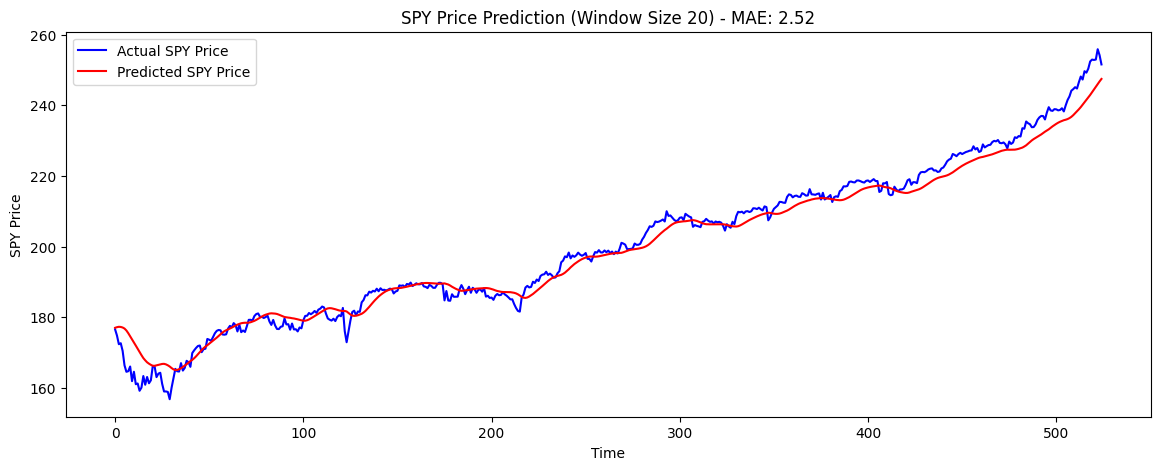

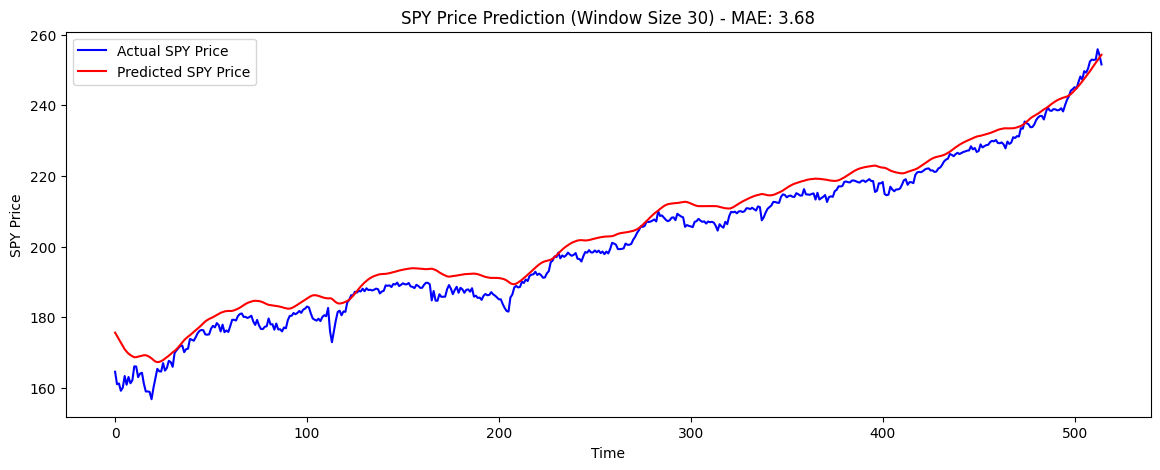

In [5]:
# Calculate MAE for window size 20
mae_20 = mean_absolute_error(actual_20, predictions_20)
print(f'MAE for window size 20: {mae_20}')

# Calculate MAE for window size 30
mae_30 = mean_absolute_error(actual_30, predictions_30)
print(f'MAE for window size 30: {mae_30}')

# Plot the results for window size 20
plt.figure(figsize=(14, 5))
plt.plot(actual_20, color='blue', label='Actual SPY Price')
plt.plot(predictions_20, color='red', label='Predicted SPY Price')
plt.title(f'SPY Price Prediction (Window Size 20) - MAE: {mae_20:.2f}')
plt.xlabel('Time')
plt.ylabel('SPY Price')
plt.legend()
plt.show()

# Plot the results for window size 30
plt.figure(figsize=(14, 5))
plt.plot(actual_30, color='blue', label='Actual SPY Price')
plt.plot(predictions_30, color='red', label='Predicted SPY Price')
plt.title(f'SPY Price Prediction (Window Size 30) - MAE: {mae_30:.2f}')
plt.xlabel('Time')
plt.ylabel('SPY Price')
plt.legend()
plt.show()